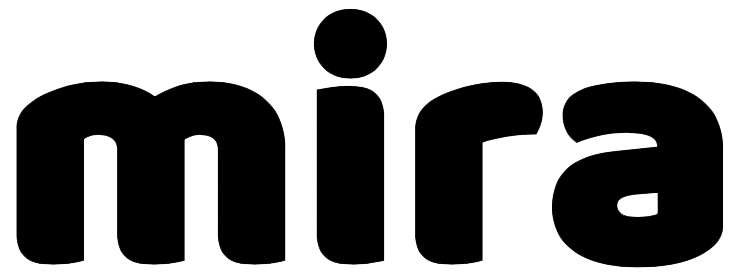

MIRA is a python package and statistical methodology for analyzing single-cell multiomics data - or sc-RNA-seq and scATAC-seq in the same cell. 

This tutorial assumes:
   * You have experience in single-cell analysis
   * You are familiar with python
   * You have previously worked with ``scanpy``
   
## What does MIRA do?

## Part 1: Topic modeling
<br>
<b>
<ol>
    <li>Represents cells in joint expression and accessibility space.</li>
    <li>Performs lineage inference and visualization</li>
    <li>Identifies patterns of co-regulation in data</li>
</ol>
</b>

In [1]:
import mira
import scanpy as sc
import anndata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
DIR = '/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/'

## Getting started

#### Installation
To start, you can install MIRA from conda or PyPi:<br><br>
``
conda install -c conda-forge -c bioconda -c liulab-dfci mira-multiome
``

#### Data
MIRA just needs scRNA-seq and scATAC-seq count matrices from a multiomics experiment. No pre-processing of the counts is required.

Fist, we'll import some data. Today, we'll analyze the SHARE-seq skin dataset used in our [manuscript](https://www.biorxiv.org/content/10.1101/2021.12.06.471401v1.full.pdf).

In [2]:
rna_data = anndata.read_h5ad(DIR + 'rna_data_raw_counts_only.h5ad')
rna_data.var_names = rna_data.var_names.str.upper()
rna_data.var_names_make_unique()
atac_data = anndata.read_h5ad(DIR + 'atac_data_raw_counts_only.h5ad')
cell_metadata = pd.read_csv(DIR + 'cell_metadata.tsv', sep = '\t')
cell_metadata = pd.read_csv(DIR + 'cell_metadata.tsv', sep = '\t').set_index('barcode')
rna_data = rna_data[cell_metadata.index.values]
rna_data.obs = rna_data.obs.join(cell_metadata[['celltype','true_cell']], how = 'left')
rna_data.obs.true_cell = rna_data.obs.true_cell.astype(str)
atac_data = atac_data[rna_data.obs_names]

rna_data.raw = rna_data
sc.pp.normalize_total(rna_data, target_sum=1e4)
rna_data.layers['normalized'] = rna_data.X.copy()
rna_data.X = rna_data.raw.to_adata().X

### Part 1.1: Joint expression and accessibility representation

The first thing we need to do when analyzing a new dataset is to train a **MIRA topic model**.

A topic model finds "topics" of co-regulated elements in single-cell data. For instance, an expression topic may be a group of genes that are coregulated by some signaling element. Then, the model represents cells as a composition of those topics depending on which genes are active.

In [3]:
rna_model = mira.topics.ExpressionTopicModel.load(DIR + 'shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load(DIR + 'shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


With a trained topic model, the first thing we can do is find the topic compositions of our cells:

In [4]:
rna_model.predict(rna_data)
atac_model.predict(atac_data)

Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.61it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████| 56/56 [00:42<00:00,  1.33it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23


The model is constrained such that the cell-topic compositions are sparse, so only a few topics may describe any given cell:

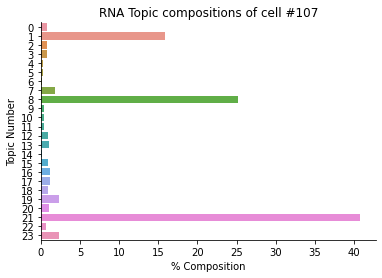

In [5]:
ax = sns.barplot(y = np.arange(rna_model.num_topics).astype(str), x = 100*rna_data.obsm['X_topic_compositions'][107])
ax.set(xlabel = '% Composition', ylabel = 'Topic Number', title = 'RNA Topic compositions of cell #107')
sns.despine()

We have found expression and accessibility topic compositions for each cell. Let's combine them into a joint representation to visualize the dataset. 

First, we need to transform the topic compositions into a numerical basis that can be used to find inter-cell distances. We transform the topic compositions using the ``get_umap_features`` command.

In [6]:
rna_model.get_umap_features(rna_data, box_cox=0.25)
atac_model.get_umap_features(atac_data, box_cox=0.25)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


Then, we use ``mira.utils.make_joint_representation`` to combine the transformed spaces for each modality into a joint representation for each cell:

In [7]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.utils:28429 out of 28429 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


Finally, we can use scanpy to define a KNN graph of cells using the joint space representation. The resulting KNN graph identifies cells in similar states based on both modalities. 

In [8]:
sc.pp.neighbors(rna_data, use_rep='X_joint_umap_features', metric='manhattan')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


With a joint KNN graph, there's a variety of useful things we can do. For instance, clustering and UMAP visualiztion:

In [9]:
sc.tl.umap(rna_data, min_dist = 0.1)

In [10]:
populations = ['Cortex', 'IRS', 'Inner Bulge', 'Inner Infandibulum',
       'Inner Matrix', 'Isthmus', 'Lower Basal', 'Lower Granular',
       'Lower Outer Bulge', 'Lower Spinous', 'Matrix', 'Medulla', 'ORS',
       'Outer Infandibulum', 'Outer Matrix', 'Upper Basal',
       'Upper Basal Cycling', 'Upper Granular', 'Upper Outer Bulge',
       'Upper Spinous']

rna_data = rna_data[rna_data.obs.true_cell.isin(populations)]
atac_data = atac_data[rna_data.obs_names]

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(n

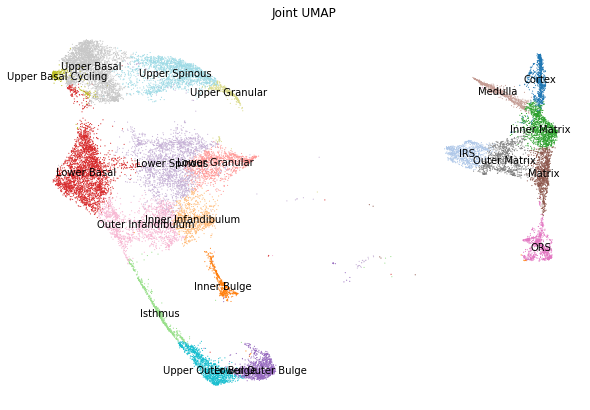

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sc.pl.umap(rna_data, color = 'true_cell', frameon = False, palette = 'tab20', title = 'Joint UMAP',
           ax = ax, show =False, legend_loc = 'on data', legend_fontweight=500)
ax.invert_yaxis()
plt.show()

### Part 1.2: Lineage inference using the joint KNN graph

The joint KNN graph encodes paths between cells in similar states. We can exploit this to identify lineages using both modalities. Let's focus in on a group of cells that are undergoing differentiation:

In [12]:
from matplotlib import patches

with open(DIR + 'HF_cells.txt','r') as f:
    hf_cells = [x.strip() for x in f]

hair_follicle = rna_data[hf_cells]
sc.pp.neighbors(hair_follicle, use_rep='X_joint_umap_features', metric='manhattan')
sc.tl.umap(hair_follicle, min_dist = 0.1)

In [13]:
theta = np.radians(120)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
hair_follicle.obsm['X_umap_rot'] = np.dot(hair_follicle.obsm['X_umap'], R)*np.array([[1,-1]])
hair_follicle.obsm['X_umap'] = hair_follicle.obsm['X_umap_rot']

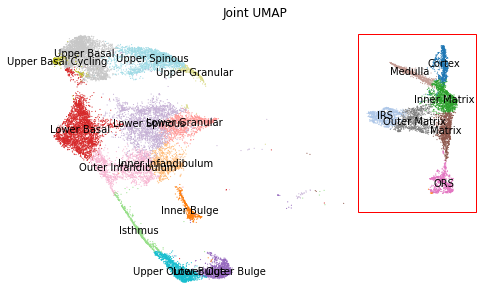

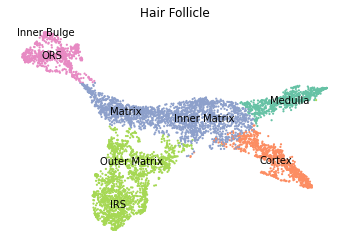

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.umap(rna_data, color = 'true_cell', frameon = False, palette = 'tab20', title = 'Joint UMAP',
           ax = ax, show =False, legend_loc = 'on data', legend_fontweight=500)
ax.invert_yaxis()
ax.add_artist(patches.Rectangle((10,-5),5.5,13, alpha = 1, fill = None, linewidth = 1, color = 'red'))
plt.show()

HF_colors = {
    celltype : sns.color_palette('Set2')[i]
    for celltype, i in zip(
        ['Inner Bulge','ORS','Matrix','Inner Matrix','Medulla','Cortex','IRS','Outer Matrix'],
        [3,3,2,2,0,1,4,4]
    )
}

fig, ax = plt.subplots(1,1,figsize=(6,4))
sc.pl.embedding(hair_follicle, basis = 'X_umap_rot', color = 'true_cell', frameon = False, 
        palette = HF_colors, 
        title = 'Hair Follicle', ax = ax, show =False, legend_loc = 'on data', legend_fontweight=500)
#ax.invert_xaxis()
plt.show()

The MIRA lineage inference algorith requires just a start cell, and optionally user-provided terminal cells. You must follow these steps:

#### 1. Make a diffusion map of the data

In [15]:
sc.tl.diffmap(hair_follicle)
mira.time.normalize_diffmap(hair_follicle)
sc.pp.neighbors(hair_follicle, use_rep='X_diffmap', key_added='X_diffmap')
mira.time.get_connected_components(hair_follicle)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 5 components.
INFO:root:Added key to uns: eigen_gap
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


#### 2. Make the forward Markov matrix

In [16]:
mira.time.get_transport_map(hair_follicle, 
        start_cell=atac_data[hair_follicle.obs_names].obs.topic_10.argmax()
)

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
Calculating pseudotime:   4%|██▊                                                                   | 2378/59450 [00:00<00:08, 6732.19it/s]
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: iroot


#### 3. Choose terminal states and get lineage probabilities

In [17]:
terminal_cells = [3058, 5417, 4524]
#mira.time.find_terminal_cells(hair_follicle, threshold=1e-2, max_termini=50)

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


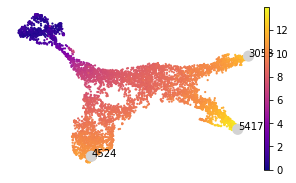

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
sc.pl.embedding(hair_follicle, basis = 'X_umap_rot',
                color = 'mira_pseudotime', color_map='plasma', frameon=False, ax = ax, show = False)
sc.pl.embedding(hair_follicle[terminal_cells], basis = 'X_umap_rot',
                size = 500,frameon=False, ax = ax, show = False)
for t in terminal_cells:
    c = hair_follicle[t].obsm['X_umap_rot'].reshape(-1)
    ax.text(x = c[0], y = c[1], s = str(t))

In [19]:
mira.time.get_branch_probabilities(hair_follicle, 
                terminal_cells={'Medulla' : 3058, 'Cortex' : 5417, 'IRS' : 4524}
)

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


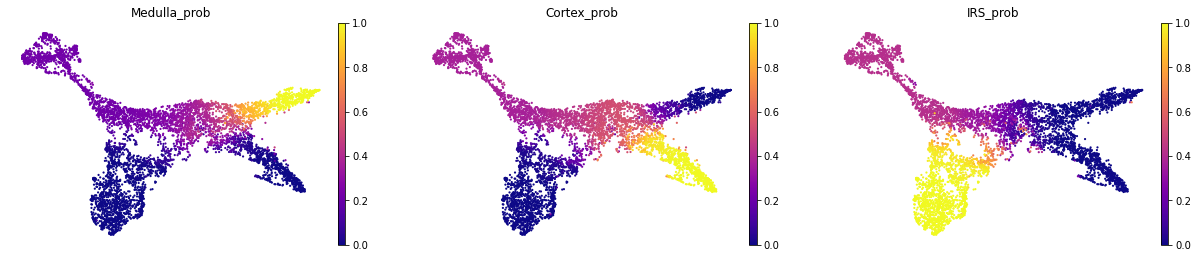

In [20]:
sc.pl.embedding(hair_follicle, basis = 'X_umap_rot', color = ['Medulla_prob','Cortex_prob','IRS_prob'],
               frameon=False, color_map = 'plasma')

#### 4. Parse lineage structure 

In [21]:
mira.time.get_tree_structure(hair_follicle, threshold=0.5)

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree


/Users/alynch/projects/multiomics/mira/mira/mira/plots/swarmplot.py:200: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... st

<AxesSubplot:title={'center':'true_cell'}, xlabel='X_umap_rot1', ylabel='X_umap_rot2'>

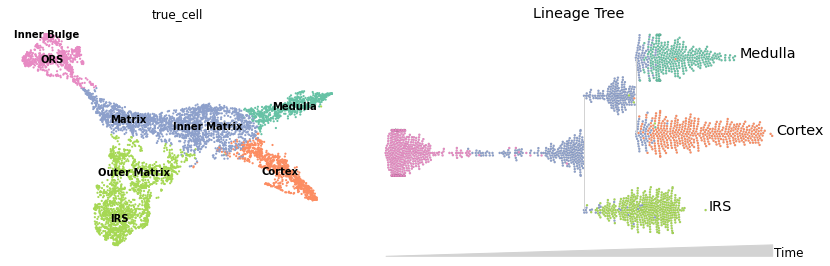

In [22]:
fig, ax = plt.subplots(1,2,figsize=(12,4), gridspec_kw=(dict(width_ratios = [2,2.5])))
hair_follicle.obs['true_cell'] = hair_follicle.obs.true_cell.astype(str)
mira.pl.plot_stream(hair_follicle, data = ['true_cell'], max_swarm_density=100,
                    palette=list(HF_colors.values()), hue_order = list(HF_colors.keys()),
                    style = 'swarm', show_legend=False, title = 'Lineage Tree',
                   log_pseudotime=False, size = 5, linewidth=0.04, ax = ax[1])

sc.pl.embedding(hair_follicle, basis = 'X_umap_rot', color = 'true_cell', palette=HF_colors,
               frameon=False, show = False, ax = ax[0], legend_loc='on data')

#### Important feature:

``mira.pl.plot_stream``

Is a workhorse for analyzing regulatory dynamics over timecourses. This plot has four modes you can use to analyze data:
1. Swarm mode
2. Stream mode
3. Scatter/Line mode
4. Heatmap model

In [23]:
hair_follicle.layers['smoothed'] = hair_follicle.obsp['connectivities'].dot(hair_follicle.layers['normalized'])
hair_follicle.layers['log_norm'] = np.log1p(hair_follicle.layers['normalized'])

**Stream** mode can show high-dimensional comparisons between many features over the lineage tree:

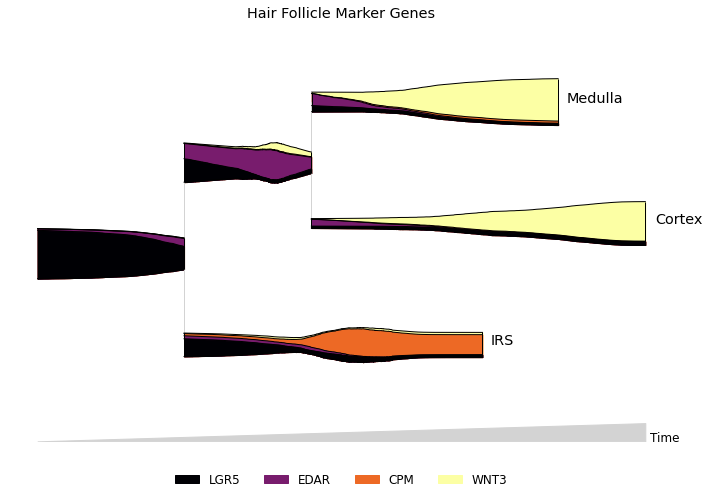

In [24]:
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 5], palette='inferno',
                    data = ['LGR5','EDAR','WNT3','CPM',], style = 'stream', clip = 2,
                    max_bar_height=0.99, window_size = 501, figsize=(10,7), linewidth=1,
                    log_pseudotime=False, scale_features=True, layers = 'smoothed',
                    split = False, title = 'Hair Follicle Marker Genes'
                   )
plt.show()

**Swarm** mode is good for plotting discrete or sparse values, like cluster identity or Expression counts:

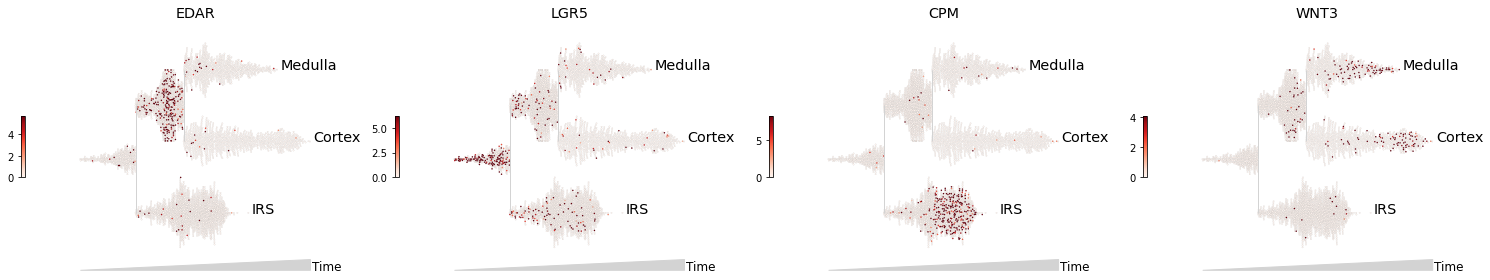

In [25]:
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 5], palette='Reds',
                    data = ['LGR5','EDAR','WNT3','CPM',], style = 'swarm',
                    max_bar_height=0.99,figsize=(20,4), clip = 2,
                    log_pseudotime=False, layers = 'normalized',
                    size = 2, linewidth=0.04,
                   )
plt.show()

**Heatmap** cannot show lineage trees, but works best for comparing a large number of features at once:

(<Figure size 720x144 with 1 Axes>, <AxesSubplot:>)

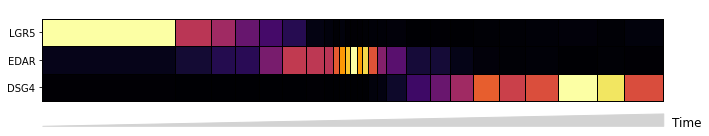

In [26]:
mira.pl.plot_stream(
    hair_follicle[(hair_follicle.obs.mira_pseudotime > 5) & hair_follicle.obs.tree_states.str.contains('Cortex')],
    style = 'heatmap', data = ['LGR5','EDAR','DSG4'], palette='inferno', 
    scale_features=True, layers = 'smoothed', figsize=(10, 2),
    )

## Part 1.3: Topic Analysis

We can use streams to investigate gene expression over time, but they are also useful for analyzing the flow of topic composition over the differentiation. This is where the sparsity constraint of MIRA topic model comes in handy.

We can plot topic composition projected onto the UMAP view.


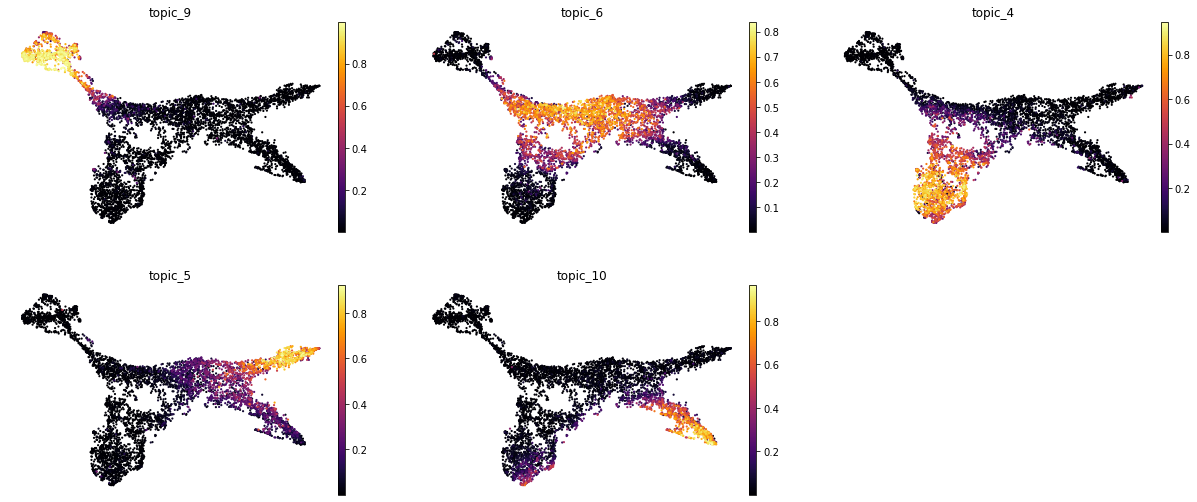

In [27]:
sc.pl.embedding(hair_follicle, basis = 'X_umap_rot', color = ['topic_' + str(i) for i in [9,6,4,5,10]],
               **mira.pref.topic_umap(ncols=3))

Remember, we also have accessibility topics from the ATAC-seq data:

In [28]:
hair_follicle.obs = hair_follicle.obs.join(atac_data[hair_follicle.obs_names]\
                                           .obs[atac_model.topic_cols], how = 'left', rsuffix='_atac')

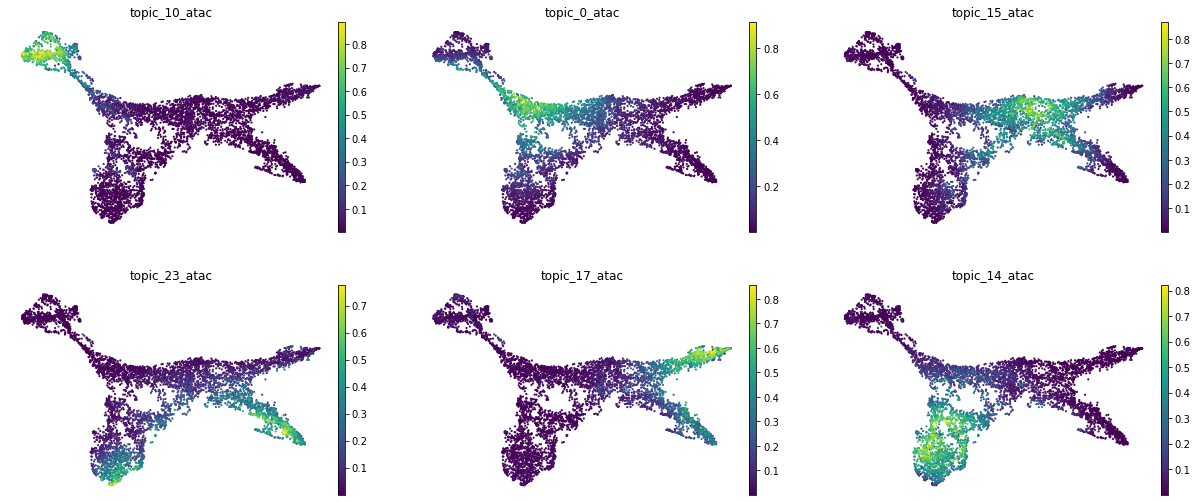

In [29]:
sc.pl.embedding(hair_follicle, basis = 'X_umap_rot', color = ['topic_' + str(i) + '_atac' for i in [10, 0, 15, 23, 17, 14]],
               **mira.pref.topic_umap(ncols=3, color_map='viridis'))

One interesting question we can ask is how does the emergence of expression topics coincide with accessibility topics? How do state changes line up between modes?

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Accessibility Topics'}>)

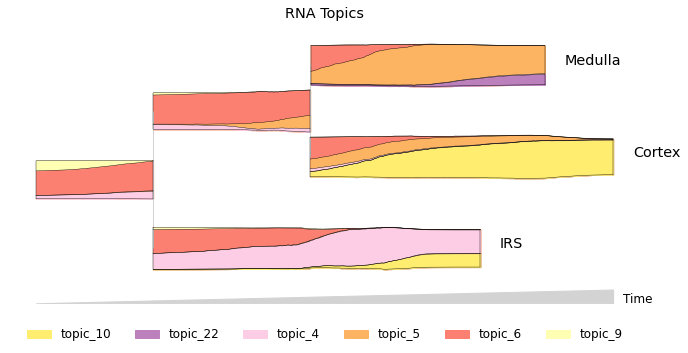

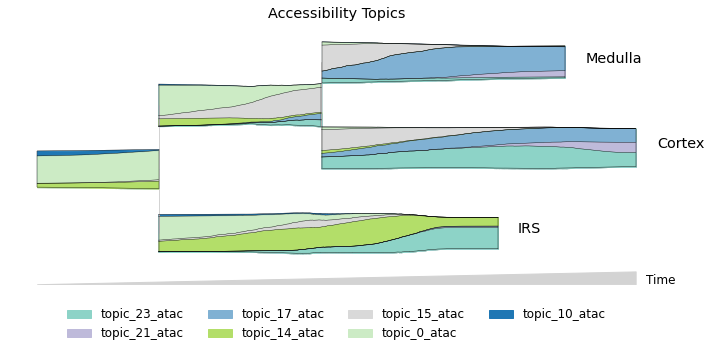

In [30]:
stream_kwargs = dict(hide_feature_threshold=0.03, window_size=301, linewidth=0.4,log_pseudotime=True)

mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 6], 
                    data = ['topic_9','topic_6','topic_10','topic_5','topic_4','topic_22'], order='descending',                      
                   palette=sns.color_palette('Set3')[1::2][::-1], legend_cols=7, 
                    title = 'RNA Topics',**stream_kwargs)

mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 6], order = 'descending', title = 'Accessibility Topics',
                    data = ['topic_10_atac','topic_0_atac','topic_15_atac','topic_17_atac','topic_14_atac','topic_23_atac', 'topic_21_atac'],
                   palette=[*sns.color_palette('Set3')[::2], *sns.color_palette('tab20')[:2]],legend_cols=4, **stream_kwargs)

**What does each topic mean?** We can use enrichment analysis to find out.

For expression topics, we simply take the top *n* genes and perform gene set enrichment analysis to find overlaps with precompiled ontologies. We use ``Enrichr``.

INFO:charset_normalizer:ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO:charset_normalizer:ascii should target any language(s) of ['Latin Based']
INFO:charset_normalizer:We detected language [('English', 1.0), ('Dutch', 1.0), ('Norwegian', 1.0), ('Indonesian', 1.0), ('Polish', 1.0)] using ascii
INFO:charset_normalizer:ascii is most likely the one. Stopping the process.


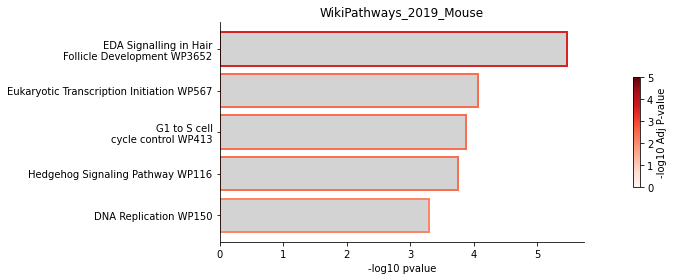

In [31]:
rna_model.post_topic(6, top_n=500)
rna_model.fetch_topic_enrichments(6, ontologies=['WikiPathways_2019_Mouse'])
rna_model.plot_enrichments(6, show_top=5, show_genes = False)

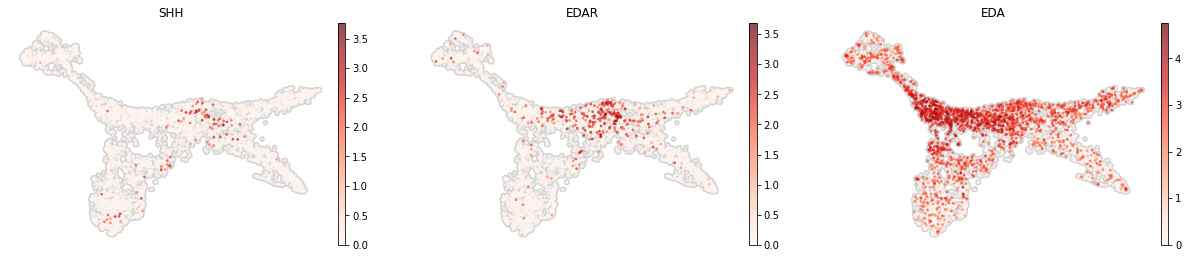

In [32]:
sc.pl.umap(hair_follicle, color = ['SHH','EDAR','EDA'], layer = 'log_norm', **mira.pref.raw_umap())

For accessibility topics, we can find the top transcription factor regulators that bind in peaks with the strongest association with that topic. First, we have to call motif or ChIP hits in our peaks using either:
``mira.tl.get_motif_hits_in_peaks`` or ``mira.tl.get_ChIP_hits_in_peaks``.

I ran the command below ahead-of-time, so we will load the results and continue.
```
mira.tl.get_motif_hits_in_peaks(atac_data, genome_fasta='/Users/alynch/genomes/mm10/mm10.fa')
```

In [33]:
atac_data = anndata.read_h5ad('data/shareseq/tutorial/atac_data_motifs.h5ad')

We can use ``mira.utils.subset_factors`` to down-select which factors we are analyzing. Often, it is convenient to limit the analysis to motifs that represent factors that you have measured expression for:

In [34]:
mira.utils.subset_factors(atac_data, use_factors= rna_data.var_names[np.array(rna_data.X.sum(0)).reshape(-1) > 50])

INFO:mira.adata_interface.utils:Found 412 factors in expression data.


Then, we get enrichments of factors in the top peaks associated with the topics of interest:

In [35]:
atac_model.get_enriched_TFs(atac_data, topic_num = 15, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num = 23, top_quantile=0.1)

Finding enrichments: 100%|█████████████████████████████████████████████████████████████████████████████| 412/412 [00:02<00:00, 187.04it/s]


Finally, it is most effective to analyze influential factors by juxtaposing the transition between similar topics. We can see below that the transition from topic 15 to topic 23 is fascilitated by increasing influence of terminal HF-specific factor HOXC13 using ``atac_model.plot_compare_module_enrichments``.

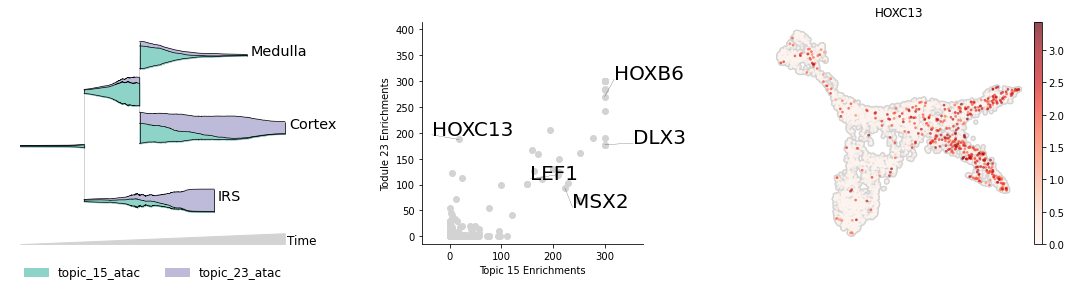

In [36]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 5],
                    data = ['topic_15_atac','topic_23_atac'],
                   palette=[*sns.color_palette('Set3')[::2], *sns.color_palette('tab20')[:2]],
                    legend_cols=4, log_pseudotime=False, hide_feature_threshold=0., linewidth=0.7,
                   ax = ax[0])

atac_model.plot_compare_topic_enrichments(15, 23, 
        label_factors=['LEF1','HOXC13','HOXB6','DLX3','MSX2'], fontsize=20,
        color = 'lightgrey', ax = ax[1],
)
ax[1].axis('square')

sc.pl.embedding(hair_follicle, basis='X_umap_rot', color = 'HOXC13', 
                layer = 'log_norm', **mira.pref.raw_umap(), show = False, ax = ax[2])
plt.show()

**Part 1 Summary**: Using streams and topics, one can find key regulators and identify drivers of state transitions while comparing and contrasting modes for a deeper understanding of multiomics data.


# Part 2: Regulatory Dynamics

One of the key advantages of multiomics data is the ability to study *cis*-regulatory relationships between genes and their local chromatin. We learn regulatory relationships between genes and chromatin using RP models. In this section, we will cover:

<br>
<b>
    <ol>
        <li>Learn <i>cis</i>-regulatory relationships.</li>
        <li>Finding genes where local chromatin and expression are out of sync.</li>
        <li>Identifying transcription factor drivers of expression.</li>
    </ol>
</b>

### Part 2.1: Training RP models

We'll start by training models for a couple of genes. The ``LITE_Model`` stands for **L**ocally-**I**nfluenced **T**ranscriptional **E**xpression model, and it integrates local chromatin around a gene to try to predict it's expression.

Before we start, we have to give MIRA gene locations so that the RP model knows how far peaks are away from the TSS. I loaded in a dataframe with the required gene information (chrom, name, start, end, strand):

In [37]:
tss_data = pd.read_csv(DIR + 'mm10_canonical_tss.tsv', sep = '\t')
tss_data.head(3)

,name,chrom,strand,txStart,txEnd,geneSymbol,chromStart,chromEnd,transcript
0,ENSMUST00000193812.1,chr1,+,3073252,3074322,4933401J01RIK,3073252.0,3074322.0,ENSMUST00000193812.1
1,ENSMUST00000082908.1,chr1,+,3102015,3102125,GM26206,3102015.0,3102125.0,ENSMUST00000082908.1
2,ENSMUST00000159265.1,chr1,-,3206522,3215632,XKR4,NaN,NaN,NaN


And provided that to ``mira.tl.get_distance_to_TSS`` to mark gene locations and find peak-gene distances:

In [38]:
mira.tl.get_distance_to_TSS(atac_data, tss_data= tss_data, genome_file=DIR + 'mm10.genome')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


Next, we instantiate a ``LITE_Model``:

In [39]:
litemodel = mira.rp.LITE_Model(expr_model=rna_model, accessibility_model=atac_model, 
                              genes = ['BRAF','KRT23','RNASET2B'])

To fit a model, you provide both your RNA and ATAC-seq data aligned at the barcode:

In [40]:
atac_data = atac_data[rna_data.obs_names]

In [41]:
litemodel.fit(atac_adata = atac_data, expr_adata = rna_data)

litemodel.predict(atac_adata = atac_data[hair_follicle.obs_names], expr_adata = hair_follicle)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...
Calculating softmax summary data: 100%|██████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 100.42it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...
Calculating softmax summary data: 100%|███████████████████████████████████████████████████████████████████| 49/49 [00:22<00:00,  2.21it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
Trying to set attribute `.obs` of view, copying.
Fitting models: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.35s/it]
INFO:mira.adata_interface.core:Added cols to obs: model_r

The ``LITE_Model`` learns upstream and downstream decay rates of local *cis*-regulatory influence for each gene:

In [42]:
litemodel.get_model('KRT23').get_normalized_params()

{'a': array([1.4562697 , 0.9563395 , 0.29904735], dtype=float32),
 'distance': array([16.325203, 15.382601], dtype=float32),
 'theta': array(0.39883372, dtype=float32),
 'gamma': array(1.0487652, dtype=float32),
 'bias': array(-0.2228213, dtype=float32),
 'bn_mean': array([0.4610255], dtype=float32),
 'bn_var': array([0.025834125], dtype=float32),
 'bn_eps': 1e-05}

# Part 2.2: Comparing RP model predictions to expression

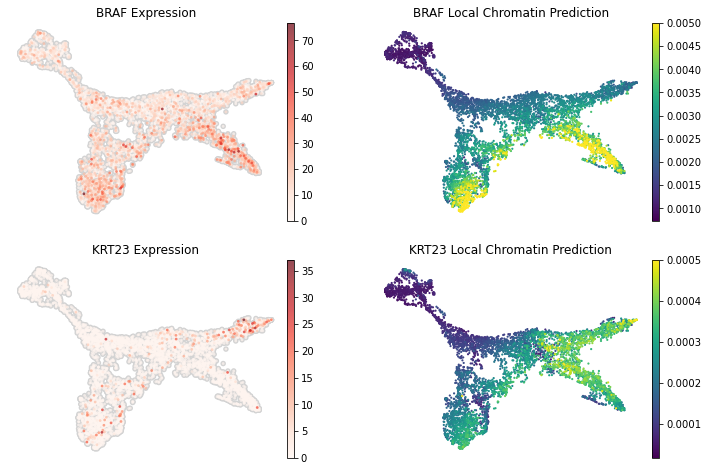

In [43]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
for i, (gene, vmax) in enumerate(zip(litemodel.genes, [0.005, 0.0005])):
    sc.pl.embedding(hair_follicle, color = gene, **mira.pref.raw_umap(), layer='normalized', ax = ax[i,0], show = False,
              title = gene + ' Expression', basis = 'X_umap_rot')
    sc.pl.embedding(hair_follicle, color = gene, color_map = 'viridis', frameon=False, 
               layer='LITE_prediction', ax = ax[i,1], show = False, basis = 'X_umap_rot',
              title = gene + ' Local Chromatin Prediction', vmax = vmax)

The local chromatin prediction for BRAF look pretty good! But for KRT23, less so. This presents an interesting case where local chromatin does not seem to explain changes in expression. To quantify this effect, we need to train another model: the ``NITE_Model``, or **N**on-locally **I**nfluenced **T**ranscriptional **E**xpression model. This model uses information from the accessibility topic model to predict expression not just from the local chromatin around a gene, but from the cell's global chromatin state.

In [44]:
nitemodel = mira.rp.NITE_Model(expr_model=rna_model, accessibility_model=atac_model, 
                              genes = ['BRAF','KRT23'], initialization_model=litemodel)
nitemodel.fit(atac_adata = atac_data, expr_adata = rna_data)

nitemodel.predict(atac_adata = atac_data[hair_follicle.obs_names], expr_adata = hair_follicle)

Predicting expression: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]
INFO:mira.adata_interface.core:Added layer: NITE_prediction


Comparing the LITE model prediction the NITE model prediction:

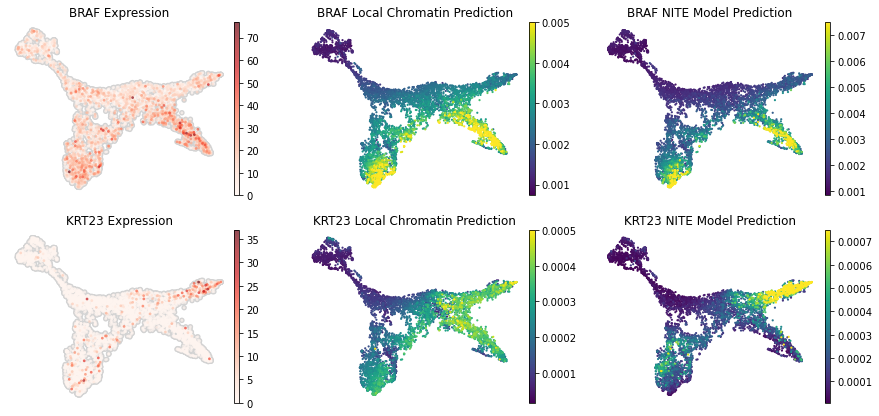

In [45]:
fig, ax = plt.subplots(2,3,figsize=(15,7))
for i, (gene, vmax) in enumerate(zip(litemodel.genes, [0.005, 0.0005])):
    sc.pl.embedding(hair_follicle, color = gene, **mira.pref.raw_umap(), layer='normalized', ax = ax[i,0], show = False,
              title = gene + ' Expression', basis = 'X_umap_rot')
    
    sc.pl.embedding(hair_follicle, color = gene, color_map = 'viridis', frameon=False, 
               layer='LITE_prediction', ax = ax[i,1], show = False, basis = 'X_umap_rot',
              title = gene + ' Local Chromatin Prediction', vmax = vmax)
    
    sc.pl.embedding(hair_follicle, color = gene, color_map = 'viridis', frameon=False, 
               layer='NITE_prediction', ax = ax[i,2], show = False, basis = 'X_umap_rot',
              title = gene + ' NITE Model Prediction', vmax = 1.5*vmax)

The ``NITE_Model`` incorporating genome-wide information will always predict expression better than the local-only ``LITE_Model``. And we can compare the predictions of the model at a per-cell basis to see where local chromatin is over or under-estimating expression using ``mira.tl.get_chromatin_differential``:

In [46]:
mira.tl.get_chromatin_differential(hair_follicle)

INFO:mira.adata_interface.core:Added layer: chromatin_differential


Use ``mira.pl.plot_chromatin_differential`` to show panels for genes. Notice **chromatin_differential** indicates that local chromatin accessibility strongly over-estimated observed gene expression for KRT23 in Cortex cells.

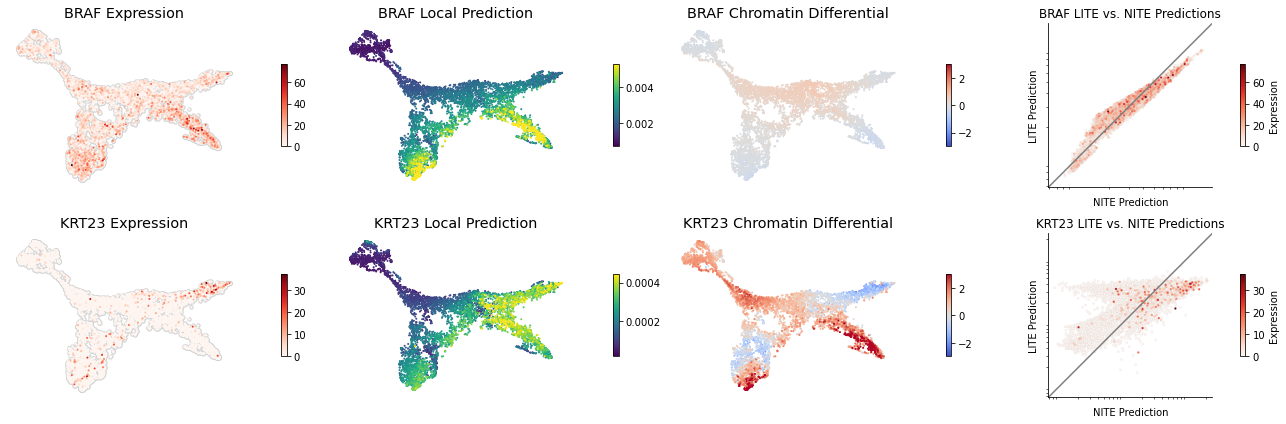

In [47]:
mira.pl.plot_chromatin_differential(hair_follicle, genes = ['BRAF','KRT23'], counts_layer='normalized',
                                   trim_lite_prediction=2)
plt.show()

Another way we can investigate differences between local chromatin and expression is with streams. Using the **line** mode of ``mira.pl.plot_stream``, we can quantitatively compare levels of the two modes:

(<Figure size 504x288 with 1 Axes>, <AxesSubplot:>)

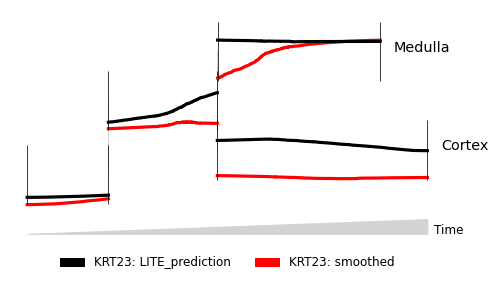

In [48]:
mira.pl.plot_stream(
    hair_follicle[(hair_follicle.obs.mira_pseudotime > 6) \
                  & hair_follicle.obs.tree_states.str.contains('Cortex|Medulla')], 
                    data = ['KRT23','KRT23'], layers = ['LITE_prediction','smoothed'], figsize = (7,4),
                   palette=['black','red'], order = None, style = 'line', scale_features=True,
                   log_pseudotime=True, window_size=501, clip = 2, size = 10)

We can quantify the strength of the decoupling of expression and accessibility for each gene by calculating a **NITE score** for that gene. First, run the ``get_logp`` function with both models:

In [49]:
litemodel.get_logp(atac_adata = atac_data, expr_adata = rna_data)
nitemodel.get_logp(atac_adata = atac_data, expr_adata = rna_data)

Getting logp(Data):   0%|                                                                                           | 0/3 [00:00<?, ?it/s]/Users/alynch/projects/multiomics/mira/mira/mira/rp_model/rp_model.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
Getting logp(Data): 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]
INFO:mira.adata_interface.core:Added layer: LITE_logp
Getting logp(Data): 100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.80it/s]
INFO:mira.adata_interface.core:Added layer: NITE_logp


Then, ``mira.tl.get_NITE_score_genes``:

(this function calculates statistics across many genes to calculate a NITE score that is not subject to variablility due to differences in count distributions. Since we are only using two genes, I manually specify a statistic).

In [50]:
mira.tl.get_NITE_score_genes(rna_data, median_nonzero_expression=231)

INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts


As expected, KRT23 has a much higher NITE score than BRAF. 

In [51]:
rna_data.var.loc[['BRAF','KRT23']]['NITE_score']

gene
BRAF      7.199911
KRT23    57.941210
Name: NITE_score, dtype: float64

Now, let's load in data with close to 5000 genes tested.

In [52]:
rna_data = anndata.read_h5ad(DIR + 'checkpoint_rna_data.h5ad')

In [53]:
mira.tl.get_chromatin_differential(rna_data)
mira.tl.get_NITE_score_genes(rna_data)

INFO:mira.adata_interface.core:Added layer: chromatin_differential
INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts


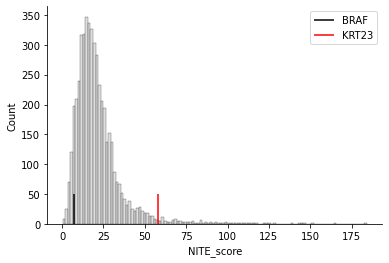

In [54]:
ax = sns.histplot(rna_data.var.NITE_score, color = 'lightgrey')
ax.vlines(7.198228, ymin = 0, ymax = 50, label = 'BRAF', color = 'black')
ax.vlines(57.941509, ymin = 0, ymax = 50, label = 'KRT23', color = 'red')
ax.legend()
sns.despine()

With many genes tested, one can also find the NITE score for entire cell states across genes. The cell-level NITE score determines how well local chromatin state in the cell predicts expression observed from that cell.

In [55]:
mira.tl.get_NITE_score_cells(rna_data)

INFO:mira.adata_interface.lite_nite:Added keys to obs: NITE_score, nonzero_counts


In the hair follicle, the Cortex and Medulla lineages showed the most NITE-style gene expression. Interestingly, in all three systems we tested, terminal gene expression was more NITE than early differentiation expression.

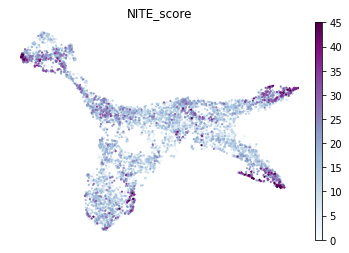

In [56]:
hair_follicle.obs['NITE_score'] = rna_data[hair_follicle.obs_names].obs.NITE_score
sc.pl.umap(hair_follicle, color = 'NITE_score', vmin = 0, vmax = 45, color_map='BuPu', frameon=False)


# Part 2.3: Predicting driver TF expression using RP models

Finally, we can use RP models to predict drivers of gene expression based on occupancy of transcription factors in local chromatin around the gene.

We use an algorithm called **P**robabilistic **I**n-**S**ilico **Deletion** (pISD), which compares the ability of the RP model to predict expression before and after the binding sites of a certain TF are masked.

In [57]:
litemodel.probabilistic_isd(atac_adata = atac_data, expr_adata = rna_data, n_samples = 1000,
                           )

Predicting TF influence: 100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]
INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [58]:
isd = mira.utils.fetch_ISD_matrix(rna_data)
isd

,SMAD4,SRF,HOXC13,GLI2,FOXK1,RUNX2,CREB3L2,NR4A2::RXRA,MLXIPL,MGP,...,FOSL1::JUND,RREB1,STAT6,HOXA9,HOXB4,NR1H2::RXRA,NR4A2,PLAGL2,ARF2,SMAD5
gene,,,,,,,,,,,,,,,,,,,,,
BRAF,-0.000797,-0.708626,2.510710,0.574008,-1.613266,0.805583,0.337627,-0.127174,7.239373e-08,-0.331138,...,2.161874,-1.342365,1.123776,1.738892,0.147613,-0.999254,0.265921,1.068676,0.931401,-0.000797
KRT23,-0.492702,0.188374,0.169351,-1.919530,-2.517928,0.058648,-0.219264,1.509233,-3.146686e+00,0.245570,...,7.880223,0.087743,23.527774,1.089693,9.053736,-0.306517,0.166472,0.000000,-3.559920,0.314600
RNASET2B,0.000000,0.000000,0.000000,0.000009,0.000000,217.033217,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.005513,0.000000,0.000000,217.033217,0.000000,0.000000,0.000006,0.000000,0.000000


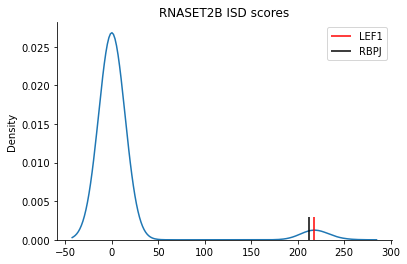

In [59]:
ax = sns.kdeplot(isd.loc['RNASET2B'].values)
for factor, color in zip(['LEF1','RBPJ'], ['red','black']):
    plt.vlines(isd.loc['RNASET2B',factor], ymin = 0, ymax = 0.003, color = color, label = factor)
plt.legend()
ax.set(title = 'RNASET2B ISD scores')
sns.despine()

ISD scores for a particular gene are noisy, so it's best to test for TF drivers across gene sets with similar regulatory dynamics to find commonly-influential factors.

I've pre-computed ISD scores for many genes:

In [60]:
rna_data = anndata.read_h5ad(DIR + 'checkpoint_rna_data.h5ad')

I will load genesets containing genes involved in Cortex and Medulla fate commitment, which we outlined in our paper.

In [61]:
with open(DIR + 'cortex_primed.txt', 'r') as f:
    cortex_primed = [x.strip() for x in f]

with open(DIR + 'medulla_primed.txt', 'r') as f:
    medulla_primed = [x.strip() for x in f]
    
with open(DIR + 'rp_model_genes.txt', 'r') as f:
    rp_genes = [x.strip() for x in f]

Then, you can compare drivers of two sets of genes by using ``mira.pl.compare_driver_TFs_plot``:

INFO:mira.tools.tf_targeting:Testing with 77 query genes and 4807 background genes, against 555 factors
Testing factors: 100%|█████████████████████████████████████████████████████████████████████████████████| 555/555 [00:01<00:00, 426.27it/s]
INFO:mira.tools.tf_targeting:Testing with 37 query genes and 4847 background genes, against 555 factors
Testing factors: 100%|█████████████████████████████████████████████████████████████████████████████████| 555/555 [00:01<00:00, 427.50it/s]


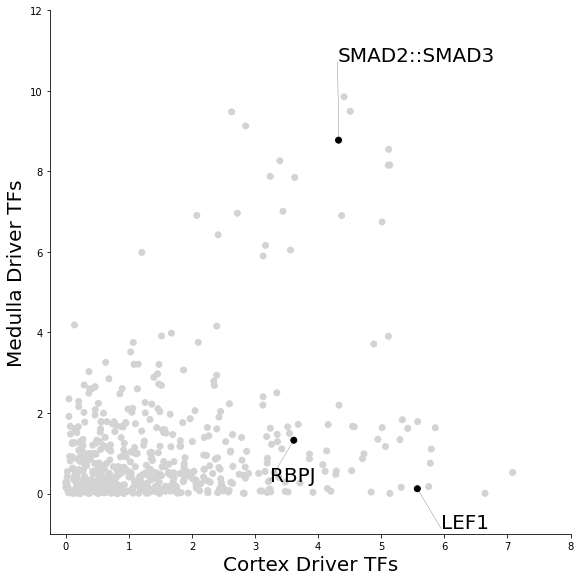

In [62]:
ax = mira.pl.compare_driver_TFs_plot(rna_data, geneset1=cortex_primed, geneset2=medulla_primed,
                               label_factors= ['LEF1','RBPJ','SMAD2::SMAD3'], color = 'lightgrey',
                               hue = {factor : 1. for factor in ['LEF1','RBPJ','SMAD2::SMAD3']},
                               palette = 'Greys_r', show_legend=False, fontsize=20,
                               axlabels = ('Cortex Driver TFs','Medulla Driver TFs'))
ax.set(xlim = (-0.25,8),ylim=(-1,12))
ax.axes.xaxis.label.set_fontsize(20)
ax.axes.yaxis.label.set_fontsize(20)
plt.savefig('docs/graphics/HF_driver_TFs.png')

# Summary

MIRA offers a comprehensive methodology for multiomics analysis that enhances many stages of single-cell data analysis:
* Visualization and clustering
* Lineage inference
* Cis-regulatory modeling
* Gene regulatory dynamics
* Regulator inference


# Acknowledgements

* Cliff Meyer*
* Christina Theodoris*
* Shirley Liu*
* Henry Long
* Myles Brown
* Center for Functional Cancer Epigenetics (CFCE)
* National Cancer Institute
